# Quantum Computing

## Bell State Tomography

### Introduction - Theoretical background

#### Bell state: 
The **Bell states** are a concept in quantum information science and represent the **simplest examples of entanglement**. [...] An EPR pair is a **pair of qubits** (or quantum bits) that are in a Bell state together, that is, **entangled with each other.** Unlike classical phenomena such as the nuclear, electromagnetic, and gravitational fields, entanglement is invariant under distance of separation[dubious – discuss] and is not subject to relativistic limitations such as the speed of light (though the no-communication theorem prevents this behaviour being used to transmit information faster than light, which would violate causality). [1]

<img src="http://image.wikifoundry.com/image/1/6ODbgusbPBYWhsqYZDIjPA10847/GW281H167">

#### Quantum state tomography:
Quantum state tomography is the **process** by which an **identical ensemble
of unknown quantum states is completely characterized.** A sequence of
identical measurements within a series of different bases allow the reconstruction
of a complete quantum wavefunction. [2]

#### IBMQX2:
It's a 5 Qubit real processor hosted at IBM, in which we could do our Quantum Computing experiments, pretty awesome.
<img src="resources/ibmqx2.PNG">

#### Philosophy:
The basic concept of our quantum program is an array of quantum circuits. The program workflow consists of three stages: Build, Compile, and Run. Build allows you to make different quantum circuits that represent the problem you are solving; Compile allows you to rewrite them to run on different backends (simulators/real chips of different quantum volumes, sizes, fidelity, etc); and Run launches the jobs. After the jobs have been run, the data is collected. There are methods for putting this data together, depending on the program. This either gives you the answer you wanted or allows you to make a better program for the next instance. [3]
<img src="https://github.com/QISKit/qiskit-sdk-py/blob/master/images/circuit_representations.png?raw=true" width="500px">
<img src="https://github.com/QISKit/qiskit-sdk-py/blob/master/images/unroller_backends.png?raw=true" width="500px">

### Quantum Code

#### Import dependencies

In [1]:
#Plotting library
import matplotlib.pyplot as plt
%matplotlib inline

#Just numpy and scipy for linear algebra
import numpy as np
from scipy import linalg as la

#Import Quantum Computing IBM API
import sys
sys.path.append("qiskit-sdk-py-master")

from qiskit import QuantumCircuit,QuantumProgram
import Qconfig

#Tomography library
import tools.qcvv.tomography as tomo

#Other packages
from tools.visualization import plot_state,plot_histogram
from tools.qi.qi import state_fidelity,concurrence,purity

#### Bell states on the ibmqx2

In [2]:
#Quantum Program Class
quantumProgram = QuantumProgram()

quantumProgram.set_api(Qconfig.APItoken,Qconfig.config["url"],verify=False) #Set the required API token

-- Ignoring SSL errors.  This is not recommended --


#### Let's look at the available backends

All the backends that are seen by QISKIT.

If ibmqx2 available we choose that backend.

In [3]:
quantumProgram.available_backends()

['ibmqx3',
 'ibmqx2',
 'ibmqx_qasm_simulator',
 'local_unitary_simulator',
 'local_qasm_simulator']

In [4]:
#Get the configuration of the backend
conf = quantumProgram.get_backend_configuration("ibmqx2",list_format=True)
#Get some config params
backend = conf['name']
shots = 1000
max_credits = 5
n = conf['n_qubits']
#Take a look at the config
conf

{'basis_gates': 'u1,u2,u3,cx,id',
 'chip_name': 'Sparrow',
 'coupling_map': [[0, 1], [0, 2], [1, 2], [3, 2], [3, 4], [4, 2]],
 'description': '5 transmon bowtie',
 'n_qubits': 5,
 'name': 'ibmqx2',
 'online_date': '2017-01-10T12:00:00.000Z',
 'simulator': False,
 'url': 'https://ibm.biz/qiskit-ibmqx2',
 'version': '1'}

#### Set up the experiment & run one circuit

**Processor register**: In computer architecture, a processor register is a quickly accessible location available to a computer's central processing unit (CPU). [4]

**Quantum register**: A quantum register is a system comprising multiple qubits[1] and is the quantum analog of the classical processor register. [5]

In [5]:
processorRegister = quantumProgram.create_classical_register(name='processorRegister',size=n,verbose=True)
quantumRegister = quantumProgram.create_quantum_register(name='quantumRegister',size=n,verbose=True)

>> new classical register created: processorRegister 5
>> new quantum_register created: quantumRegister 5


**Create quantum program circuit**: Create a empty Quantum Circuit in the Quantum Program. 

In [6]:
bell = quantumProgram.create_circuit(name='bell',cregisters=[processorRegister],qregisters=[quantumRegister])

**Create the logic**

**h:** Apply H to q.<br>
**Haddamard Gate (h):** The Hadamard transform is an example of a generalized class of Fourier transforms. It performs an orthogonal, symmetric, involutive, linear operation on 2m real numbers (or complex numbers, although the Hadamard matrices themselves are purely real). [6]

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/1010_0110_Walsh_spectrum_%28single_row%29.svg/1200px-1010_0110_Walsh_spectrum_%28single_row%29.svg.png" width="500px">
<br><br>

**cx:** Apply CNOT from ctl to tgt.<br>
**CNOT:** In computing science, the controlled NOT gate (also C-NOT or CNOT) is a quantum gate that is an essential component in the construction of a quantum computer. It can be used to entangle and disentangle EPR states. Any quantum circuit can be simulated to an arbitrary degree of accuracy using a combination of CNOT gates and single qubit rotations. The CNOT gate is the "quantization" of a classical gate. [7]
<img src="https://upload.wikimedia.org/wikipedia/en/thumb/5/58/Cnot-compared-to-xor.svg/1200px-Cnot-compared-to-xor.svg.png" width="300px">
<br><br>
**measure:** Measure quantum bit into classical bit (tuples).

In [7]:
#Haddamard Gate
bell.h(quantumRegister[0])
#CNOT
bell.cx(quantumRegister[0],quantumRegister[1])
#Measure
bell.measure(quantumRegister[0],processorRegister[0])
bell.measure(quantumRegister[1],processorRegister[1])

circuits = ['bell']

#### Execute the circuit!

In [8]:
result = quantumProgram.execute(name_of_circuits=circuits,backend=backend,max_credits=max_credits,wait=10,timeout=240)

#### Take a look at the results

{'00001': 73, '00000': 479, '00011': 434, '00010': 38}


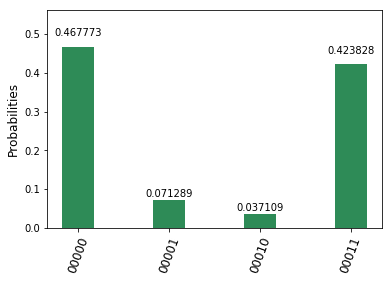

In [9]:
print(result.get_counts("bell"))
plot_histogram(result.get_counts('bell'))

#### Run tomograph

**build state tomography circuits: **Add state tomography measurement circuits to a QuantumProgram.
The quantum program must contain a circuit 'name', which is treated as a
state preparation circuit. This function then appends the circuit with a
tomographically overcomplete set of measurements in the Pauli basis for
each qubit to be measured. For n-qubit tomography this result in 3^n
measurement circuits being added to the quantum program.

**fit tomography data:** Reconstruct a density matrix or process-matrix from tomography data.

**state fidelity:** Return the state fidelity between two quantum states.

**Fidelity between quantum states:** In quantum information theory, fidelity is a measure of the "closeness" of two quantum states. It is not a metric on the space of density matrices, but it can be used to define the Bures metric on this space. [8]

# Your credits are not enough :( 

In [10]:
def tomograph(meas_qubits):
    print('meas qubits: %s' % meas_qubits)
    tomo_labels = tomo.build_state_tomography_circuits(quantumProgram,"bell_tomo",meas_qubits,quantumRegister,processorRegister)

    out = quantumProgram.execute(tomo_labels,backend,shots=shots,max_credits=max_credits,wait=20,timeout=20)

    if(str(out.get_error()) == 'Time Out'):
        print('Timed out, trying again')
        #Same but more wait and more timeout
        out = quantumProgram.execute(tomo_labels,backend,shots=shots,max_credits=max_credits,wait=40,timeout=400)
    if(str(out) != 'ERROR'):
        print('Everything is fine')
        target = np.array([1.0,0.0,0.0,1.0]/np.sqrt(2.0))
        bell_tomo_dat = tomo.fit_tomography_data(out,'bell_tomo',meas_qubits)
        rho_fit = tomo.fit_tomography_data(bell_tomo_dat,method='wizard')
        F_fit = state_fidelity(rho_fit,target)
        print('fid = %s' % str(F_fit))
        plot_state(rho_fit,"paulivec")
        
    return out

In [13]:
bell_tomo = quantumProgram.create_circuit("bell_tomo",[quantumRegister],[processorRegister])
bell_tomo.h(quantumRegister[0])
bell_tomo.cx(quantumRegister[0],quantumRegister[1])

meas_qubits = [0,1]
tomograph(meas_qubits=meas_qubits)

meas qubits: [0, 1]
>> created state tomography circuits for "bell_tomo"


ResultError: 'Your credits are not enough.'

#### Run all gates

In [ ]:
for i in conf['coupling_map']:
    meas_qubits = i
    
    tomograph(meas_qubits)
    

## References

[1] <a href="https://en.wikipedia.org/wiki/Bell_state">Wikipedia - Bell State</a>
<br>
[2] <a href="http://research.physics.illinois.edu/QI/Photonics/tomography-files/amo_tomo_chapter.pdf">Photonic State Tomography - J. B. Altepeter et al.</a>
<br>
[3] <a href="https://github.com/QISKit/qiskit-sdk-py">Github - QISKit</a>
<br>
[4] <a href="https://en.wikipedia.org/wiki/Processor_register">Wikipedia - Processor Register</a>
<br>
[5] <a href="https://en.wikipedia.org/wiki/Quantum_register">Wikipedia - Quantum Register</a>
<br>
[6] <a href="https://en.wikipedia.org/wiki/Hadamard_transform">Wikipedia - Hadamard transform</a>
<br>
[7] <a href="https://en.wikipedia.org/wiki/Controlled_NOT_gate">Wikipedia - CNOT</a>
<br>
[8] <a href="https://en.wikipedia.org/wiki/Fidelity_of_quantum_states">Wikipedia - Fidelity of quantum states
</a>
